<a href="https://colab.research.google.com/github/aprabaswara/COVID-19-Data-Analysis-Task/blob/main/COVID_19_Data_Analysis_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **COVID-19 Data Analysis Solution**

## **Created by Aditya Prabaswara Mardjikoen**

## **What is the probability of dying from COVID infection in France in March 2023 for a 25 year old? Draw the relevant correlation projections.**

We observe that the COVID-19 infection daily death probability in France and around the world keep increasing until January 2023.


Text(0.5, 1.0, 'Daily COVID-19 Death Probability in France')

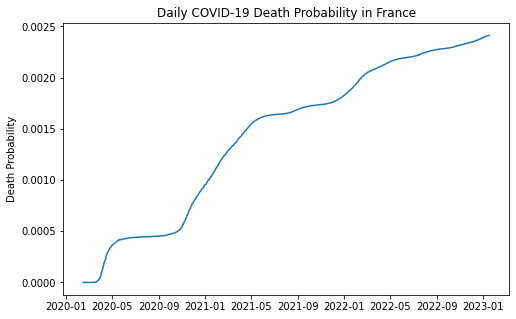

In [ ]:
# Import required library
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from pygam import LogisticGAM, s, te, f
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load the data
url = "https://raw.githubusercontent.com/owid/covid-19-data/c277e318b41ff9af90982b8873346aeda4f06832/public/data/owid-covid-data.csv"
df = pd.read_csv(url)

# Select data based on location in France
df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')
df1 = df[['date','location','median_age','population','total_deaths']][df['location']=='France']

# Plot daily death probability in France
plt.figure(figsize=(8,5))
sns.lineplot(df1['date'],df1['total_deaths']/df1['population'])
plt.xlabel('')
plt.ylabel('Death Probability')
plt.title('Daily COVID-19 Death Probability in France')

Text(0.5, 1.0, 'Worldwide Daily COVID-19 Death Probability')

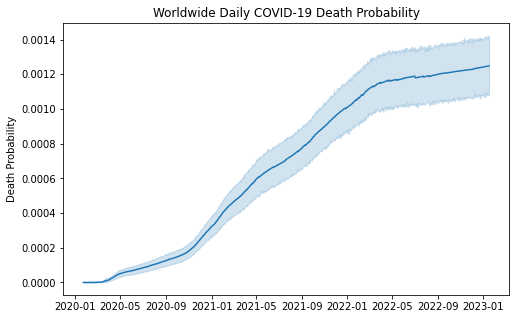

In [ ]:
# Plot worldwide daily death probability
plt.figure(figsize=(8,5))
sns.lineplot(df['date'],df['total_deaths']/df['population'])
plt.xlabel('')
plt.ylabel('Death Probability')
plt.title('Worldwide Daily COVID-19 Death Probability')

We used a Logistic Generalized Additive Model (GAM) to predict the daily death probability. The independent variable in our model is the person age and datetime variable (month, year, and day). Our model can be formulated as follows:
\begin{equation}
y = a+\sum_{i=1}^{n}f_i(X_i)
\end{equation}
where $a$ denotes the model intercept and $f_i(X_i)$ represent the spline regression function for the independent variable $X_i$.

In [ ]:
# Extract required variable in the model and compute death probability
df_model = df[['date','location','median_age','population','total_deaths']]
df_model['death_probability'] = df_model['total_deaths']/df_model['population']
df_model = df_model.drop(['population','total_deaths'],axis=1) 

# Extract year, month, and day from datetime variable
df_model['year'] = pd.to_numeric(df_model['date'].dt.year)
df_model['month'] = pd.to_numeric(df_model['date'].dt.month)
df_model['day'] = pd.to_numeric(df_model['date'].dt.day)

df_model.head()

,date,location,median_age,death_probability,year,month,day
0,2020-02-24,Afghanistan,18.6,NaN,2020,2,24
1,2020-02-25,Afghanistan,18.6,NaN,2020,2,25
2,2020-02-26,Afghanistan,18.6,NaN,2020,2,26
3,2020-02-27,Afghanistan,18.6,NaN,2020,2,27
4,2020-02-28,Afghanistan,18.6,NaN,2020,2,28


In [ ]:
# Training and fitting a generalized additive model
df_model = df_model.dropna()
y = df_model['death_probability']
date_data = df_model['date']
X = df_model.drop(['death_probability','location','date'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, shuffle=False)

gam = LogisticGAM(s(0) + s(1) + s(2) + s(3))
gam.fit(X_train, y_train)

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + s(1) + s(2) + s(3) + intercept, tol=0.0001, 
   verbose=False)

The death probabilty residual plot indicates that around 64% of the predicted death probability for the training and test data fall below its actual death probability. In addition, we can see that our MAE (Mean Absolute Error) and RMSE (Root Mean Square Error) score for the training and test data are quite small. Thus, our model performs well on predicting the daily death probability.

According to the test RMSE, we can said that the typical difference between the predicted and actual daily death probability 0.009%.

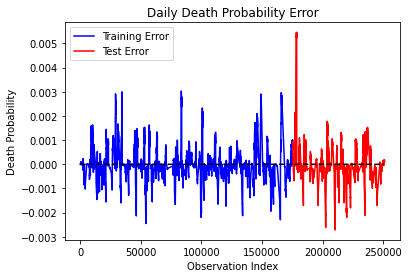

In [92]:
# Death probability residual
plt.plot(y_train-gam.predict_proba(X_train),color='blue')
plt.plot(y_test-gam.predict_proba(X_test),color='red')
plt.plot(np.zeros(250000),color='black',linestyle='dashed')
plt.xlabel('Observation Index')
plt.ylabel('Death Probability')
plt.title('Daily Death Probability Error')
plt.legend(['Training Error','Test Error'])

In [ ]:
# Percentage of negative prediction in test data
100*(y_test-gam.predict_proba(X_test) < 0).sum()/len(y_test)

63.20894589235633

In [88]:
# Percentage of negative prediction in training data
100*(y_train-gam.predict_proba(X_train) < 0).sum()/len(y_train)

64.93033226152197

In [ ]:
# Evaluation metric for training and test data
rmse_train = mean_squared_error(y_train, gam.predict_proba(X_train), squared=False)
rmse_test = mean_squared_error(y_test, gam.predict_proba(X_test), squared=False)

mae_train = mean_absolute_error(y_train, gam.predict_proba(X_train))
mae_test = mean_absolute_error(y_test, gam.predict_proba(X_test))

metric_df = pd.DataFrame({'Metric':['MAE','RMSE'],
                          'Training':[mae_train,rmse_train],
                          'Test':[mae_test,rmse_test]})
metric_df

,Metric,Training,Test
0,MAE,0.000437,0.000513
1,RMSE,0.000691,0.000892


Based on the plot below, it is estimated that the daily death probability will slightly rise from the start of March 2023 until the end of March 2023. Even though the daily death probability increase, however, the probability are less than 50%. Thus, the risk of death due to COVID-19 are quite small even though its probability still increasen.

Text(0.5, 1.0, 'Estimated Daily COVID-19 Death Probability for 25 Years Old in France')

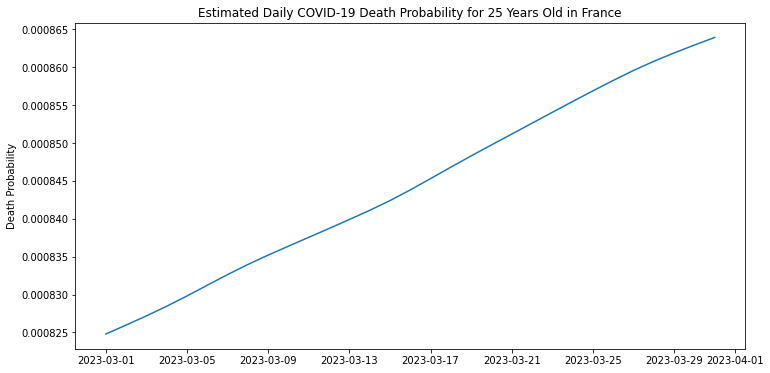

In [87]:
# Predicted daily death probability in March 2023
covid_df = pd.DataFrame({'date':pd.date_range(start="2023-03-01",end="2023-03-31"), 
                         'location': 31*['France'],'median_age':31*['25']	})
covid_df['date']= pd.to_datetime(covid_df['date'], format = '%Y-%m-%d')
covid_df['median_age'] = covid_df['median_age'].astype(str).astype(int)
covid_df['year'] = pd.to_numeric(covid_df['date'].dt.year)
covid_df['month'] = pd.to_numeric(covid_df['date'].dt.month)
covid_df['day'] = pd.to_numeric(covid_df['date'].dt.day)
covid_df['death_probability'] = gam.predict_proba(covid_df.drop(['date','location'],axis=1))

plt.figure(figsize=(12,6))
sns.lineplot(covid_df['date'],covid_df['death_probability'])
plt.xlabel('')
plt.ylabel('Death Probability')
plt.title('Estimated Daily COVID-19 Death Probability for 25 Years Old in France')

## **What is the correlation between the number of deaths with age for the US, China, France and Germany?**

We can see that the correlation between the number of deaths with age in the US are higher than in China and Germany.

In [ ]:
# Correlation between number of deaths with age based on selected countries
d = df[df['location'].isin(['United States','China','France','Germany'])]
print('Correlation between the number of deaths and age: ')
print(d.groupby('location')['total_deaths'].corr(d['median_age']))

Correlation between the number of deaths and age: 
location
China            2.083826e-15
France                    NaN
Germany         -1.318009e-16
United States    2.569154e-15
Name: total_deaths, dtype: float64
